In [18]:
# Import modules for HTML display in the notebook and enable inline mode for Matplotlib
from IPython.display import display, HTML, Math, Latex
from IPython.core.magic import register_cell_magic
  
%matplotlib inline

# Import common libraries for data manipulation, optimization, and control
import pandas as pd  # type: ignore
import cvxpy as cp  # type: ignore
from matplotlib.ticker import FuncFormatter, MultipleLocator  # type: ignore
from control.matlab import *  # type: ignore
import control.optimal as opt  # type: ignore
import control as ct  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import numpy as np  # type: ignore
import matplotlib as mpl  # type: ignore
from matplotlib.patches import FancyArrowPatch # type: ignore
from scipy.integrate import quad # type: ignore
import importlib
import itertools
import csv
import concurrent.futures
from scipy.spatial import ConvexHull
import os
import json

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

utils_path = os.path.abspath(os.path.join("..", "Utils"))
if utils_path not in sys.path:
    sys.path.append(utils_path)

# Import utility functions from custom modules
import Tex as tex
import Graphs as gph
import Signal as sgn
import Numeric as nm

importlib.reload(tex)
importlib.reload(gph)
importlib.reload(sgn)
importlib.reload(nm)

# Set the use of feedback standards for the control package
ct.use_fbs_defaults()

# Attempt to configure LaTeX for text rendering, otherwise use default Matplotlib fonts
gph.use_latex()

# Set the resolution of figures generated by Matplotlib
mpl.rcParams['figure.dpi'] = 100

@register_cell_magic
def skip(line, cell):
  return

LaTeX has been enabled for text rendering.


In [19]:
def rk5_step(f, t, x, u, T_s, params=None):
  """Executa um passo de Runge-Kutta de 5ª ordem com passo fixo."""
  k1 = f(t, x, u, params)
  k2 = f(t, x + T_s * k1 / 4, u, params)
  k3 = f(t, x + T_s * (3*k1 + 9*k2) / 32, u, params)
  k4 = f(t, x + T_s * (1932*k1 - 7200*k2 + 7296*k3) / 2197, u, params)
  k5 = f(t, x + T_s * (439*k1/216 - 8*k2 +
         3680*k3/513 - 845*k4/4104), u, params)
  k6 = f(t, x - T_s * (8*k1/27 - 2*k2 + 3544*k3 /
         2565 - 1859*k4/4104 + 11*k5/40), u, params)

  return x + T_s * (16*k1/135 + 6656*k3/12825 + 28561*k4/56430
                    - 9*k5/50 + 2*k6/55)

In [20]:
def get_A(p):
  A11 = - (1. / 4.)
  A12 = 1.
  A21 = 1.
  A22 = - (1. / 4.) + 2. * p[0]

  return np.array([[A11, A12],
                   [A21, A22]])


def get_B(p):
  B11 = 1.
  B21 = 0.
  return np.array([[B11],
                   [B21]])

In [21]:
def plant_dynamics(t, x, u, params):

  n_u = params['amounts']['u']
  n_p = params['amounts']['p']

  _u = u[0:n_u][:]
  _p = u[n_u:n_u + n_p][0]

  A = get_A(_p)
  B = get_B(_p)

  x_dot = A @ x + B @ _u

  return x_dot


def plant_output(t, x, u, params):
  return x

In [22]:
simulation_step = 1e-4
simulation_time = 60.
timepts = np.arange(0, simulation_time + simulation_step, simulation_step)

# Entrada para simulação em malha aberta
u = np.zeros((len(timepts), 1))
ρ = (0.5 * np.cos(timepts)).reshape(-1, 1)

ρ_bounds = np.array([[-.5, .5]])
φ_bounds = np.array([[-.5, .5]])

u_bar = [0.5]

params = {
    "amounts": {'x': 2, 'p': 1, 'u': 1}
}

# fig = plt.figure(figsize=(10, 2.5), layout='constrained')
# axs = fig.subplot_mosaic([['ρ']])

# gph.plot(axs['ρ'], timepts, ρ, 't (s)', '$p_1$', 'Parameter $p_1(t)$',)

In [23]:
def openloop_simulation(x0, plant_dynamics, plant_output,
                        timepts, T_s, params):
  """
  Simula um sistema de controle em malha aberta com integração RK5.

  Args:
      x0 (np.ndarray): Estado inicial, shape (n, 1)
      plant_dynamics (callable): Dinâmica do sistema f(t, x, u, params)
      plant_output (callable): Função de saída h(t, x, u, params)
      u_til (np.ndarray): Entradas estendidas, shape (N, m, 1)
      timepts (np.ndarray): Vetor de instantes de tempo, shape (N,)
      T_s (float): Passo de simulação
      params (dict): Parâmetros do sistema

  Returns:
      list[np.ndarray]: Lista com N+1 elementos, cada um de shape (n_y, 1),
                        contendo a saída em cada instante.
  """
  N = len(timepts)
  n = x0.shape[0]

  # Inicialização do estado
  x = np.zeros((n, N, 1))
  x[:, 0, :] = x0

  y = []

  for k in range(N):
    t = timepts[k]
    if k == 0:
      util = np.vstack((u[0], ρ[0]))
      y_k = plant_output(t, x0, util, params)
    else:
      util_prev = np.vstack((u[k-1], ρ[k-1]))
      util = np.vstack((u[k], ρ[k]))
      x[:, k, :] = rk5_step(plant_dynamics, timepts[k-1],
                            x[:, k-1, :], util_prev, T_s, params)
      y_k = plant_output(t, x[:, k, :], util, params)
    y.append(y_k)

  return y

In [24]:
# x0 = np.array([[.1], [.1]])
# y = openloop_simulation(x0, plant_dynamics, plant_output,
#                         timepts, simulation_step, params)

In [25]:
# fig = plt.figure(figsize=(10, 6), layout='constrained')
# axs = fig.subplot_mosaic([["x_norm"]])

# x_norm = np.array([np.linalg.norm(y_k) for y_k in y])

# gph.plot(
#     axs['x_norm'], timepts, x_norm,
#     't [s]', '$\\|x\\|$',
#     'Output norm $\\|x\\|$',
# )

In [26]:
def He(M): return M + M.T


def get_parameter(h, υ, θ, λ, ρ_bar, eps=1e-6):

  n_u = params['amounts']['u']
  n_p = params['amounts']['p']
  n_x = params['amounts']['x']
  n_z = 1

  Bnp = list(itertools.product([0, 1], repeat=n_p))
  Onx = np.zeros((n_x, n_x))
  O2nx = np.zeros((2 * n_x, 2 * n_x))

  Aρ, Aϱ = {}, {}
  Bρ, Bϱ = {}, {}

  ϱ_bounds = []
  for i in range(n_p):
    ϱ_bounds += [ρ_bar[i] + h * φ_bounds[i]]

  for i in Bnp:
    ρi = [ρ_bounds[idx][i[idx]] for idx in range(n_p)]
    ϱi = [ϱ_bounds[idx][i[idx]] for idx in range(n_p)]

    Aρ[i] = cp.Parameter((n_x, n_x), name=f'A[{i}]', value=get_A(ρi))
    Bρ[i] = cp.Parameter((n_x, n_u), name=f'B[{i}]', value=get_B(ρi))

    Aϱ[i] = cp.Parameter((n_x, n_x), name=f'A[{i}]', value=get_A(ϱi))
    Bϱ[i] = cp.Parameter((n_x, n_u), name=f'B[{i}]', value=get_B(ϱi))

  e = {}
  _es = np.eye(n_x)
  _ef = np.zeros((n_x, 4 * n_x))
  e[1] = np.block([[_es, _ef, np.zeros((n_x, 1 + n_u))]])
  e[5] = np.block([[_ef, _es, np.zeros((n_x, 1 + n_u))]])

  for i in range(2, 5):
    e[i] = np.block([[np.zeros((n_x, n_x * (i - 1))),
                      np.eye(n_x),
                      np.zeros((n_x, n_x * (5 - i))),
                      np.zeros((n_x, 1 + n_u))]])

  e[6] = np.block(
      [[np.zeros((1,  5 * n_x)), np.eye(1), np.zeros((1, n_u))]])

  e[7] = np.block(
      [[np.zeros((n_u,  5 * n_x + 1)), np.eye(n_u)]])

  for i in range(1, 8):
    e[i] = cp.Parameter(e[i].shape, value=e[i], name=f"e{i}")

  constraints = []

  Ptil = cp.Variable((n_x, n_x), PSD=True)
  Mtil = cp.Variable((2 * n_x + n_u, 2 * n_x + n_u), PSD=True)
  Q1til = cp.Variable((n_x, n_x), symmetric=True)
  Q2til = cp.Variable((n_x, n_x))
  Q3til = cp.Variable((n_x, n_u))
  Q4til = cp.Variable((n_x, n_x))
  S1til = cp.Variable((n_x, n_x), symmetric=True)
  S2til = cp.Variable((n_x, n_x))
  S3til = cp.Variable((n_x, n_u))
  S4til = cp.Variable((n_x, n_x))

  Ktil = {}
  L1til = {}
  L2til = {}
  ℵ = {}

  for i in Bnp:
    Ktil[i] = cp.Variable((n_u, n_x), name=f'K[{i}]')
    L1til[i] = cp.Variable((n_u, n_x), name=f'L1[{i}]')
    L2til[i] = cp.Variable((n_u, n_x), name=f'L2[{i}]')
    ℵ[i] = cp.Variable((n_u, n_u), diag=True)
    constraints += [ℵ[i] >> eps * np.eye(ℵ[i].shape[0])]

  Rtil = cp.Variable((n_x, n_x), PSD=True)
  Ξtil = cp.Variable((n_x, n_x), PSD=True)
  Ψtil = cp.Variable((n_x, n_x), PSD=True)
  # λ = cp.Variable(pos=True)
  # θtil = cp.Variable(pos=True)
  θtil = 1. / θ
  β = cp.Variable(pos=True)

  X = cp.Variable((n_x, n_x))
  Ytil = cp.Variable((2 * n_x, 5 * n_x + n_u + 1))

  Rcal = cp.bmat([[Rtil, Onx],
                  [Onx, 3. * Rtil]])

  Fscr = e[1].T + υ * e[2].T + υ * e[4].T

  κ1 = cp.bmat([[e[2]], [e[7]], [e[5]]])
  κ2 = cp.bmat([[e[1] - e[2]],
                [e[1] + e[2] - 2. * e[3]]])
  print(κ2.shape)

  def get_Λ(i, j, k):
    Bscr = Aρ[i] @ X @ e[1] + Bρ[i] @ Ktil[j] @ e[2] + \
        Bρ[i] @ Ktil[j] @ e[5] - Bρ[i] @ ℵ[j] @ e[7] + \
        Aϱ[k] @ X @ e[1] + Bϱ[k] @ Ktil[j] @ e[2] + \
        Bϱ[k] @ Ktil[j] @ e[5] - Bϱ[k] @ ℵ[j] @ e[7] - X @ e[4]

    e12 = e[1] - e[2]

    Θ1 = e12.T @ S1til @ e12 + \
        He(e12.T @ (S2til @ e[2] + S3til @ e[7] + S4til @ e[5]))
    Θ2 = He(e[3].T @ (Q2til @ e[2] + Q3til @ e[7] + Q4til @ e[5]))
    Θ3 = He(e[1].T @ (Q1til @ e[3] + Q2til @ e[2] +
                      Q3til @ e[7] + Q4til @ e[5]))
    Θ4 = - He(e[7].T @ ℵ[j] @ e[7] - e[7].T @ L1til[j]
              @ e[2] - e[7].T @ L2til[j] @ e[5])

    Θtil = {}
    Θtil['0'] = - λ * e[6].T @ e[6] - \
        e[5].T @ Ξtil @ e[5] - Θ1 - h * e[3].T @ Q1til @ e[3] + h * Θ3 + \
        h * κ1.T @ Mtil @ κ1 + h * e[4].T @ Rtil @ e[4] + Θ4 + \
        He(Fscr @ Bscr - κ2.T @ Ytil + e[1].T @ Ptil @ e[4])

    Θtil['h'] = - λ * e[6].T @ e[6] - \
        e[5].T @ Ξtil @ e[5] - Θ1 - h * Θ2 - h * e[3].T @ Q1til @ e[3] - \
        h * κ1.T @ Mtil @ κ1 + Θ4 + \
        He(Fscr @ Bscr - κ2.T @ Ytil + e[1].T @ Ptil @ e[4])

    Γ1_11 = Θtil['0']
    Γ1_12 = e[2].T @ X.T

    Γ1_21 = Γ1_12.T
    Γ1_22 = - Ψtil

    Γ1 = cp.bmat([[Γ1_11, Γ1_12],
                  [Γ1_21, Γ1_22]])

    Γ2_11 = Θtil['h']
    Γ2_12 = Ytil.T
    Γ2_13 = e[2].T @ X.T

    Γ2_21 = Γ2_12.T
    Γ2_22 = - (1. / h) * Rcal
    Γ2_23 = np.zeros((2 * n_x, n_x))

    Γ2_31 = Γ2_13.T
    Γ2_32 = Γ2_23.T
    Γ2_33 = - Ψtil

    Γ2 = cp.bmat([[Γ2_11, Γ2_12, Γ2_13],
                  [Γ2_21, Γ2_22, Γ2_23],
                  [Γ2_31, Γ2_32, Γ2_33]])

    return Γ1, Γ2

  binary_pairs = nm.binary_pairs(n_p)

  for pairs in binary_pairs:
    LMI_SUM = {}
    LMI_SUM['0'], LMI_SUM['h'] = 0., 0.

    for k in Bnp:
      for pair in pairs:
        Λ = {}
        Λ['0'], Λ['h'] = get_Λ(pair[0], pair[1], k)
        LMI_SUM['0'] += Λ['0']
        LMI_SUM['h'] += Λ['h']

    constraints += [LMI_SUM['0'] << -eps * np.eye(LMI_SUM['0'].shape[0])]
    constraints += [LMI_SUM['h'] << -eps * np.eye(LMI_SUM['h'].shape[0])]

  for ell in range(n_u):
    for j in Bnp:
      LMISAT11 = Ptil
      LMISAT12 = np.zeros((n_x, n_x))
      LMISAT13 = np.zeros((n_x, 1))
      LMISAT14 = (Ktil[j][ell:ell+1] - L1til[j][ell:ell+1]).T
      LMISAT15 = X.T

      LMISAT21 = LMISAT12.T
      LMISAT22 = Ξtil
      LMISAT23 = np.zeros((n_x, 1))
      LMISAT24 = (Ktil[j][ell:ell+1] - L2til[j][ell:ell+1]).T
      LMISAT25 = np.zeros((n_x, n_x))

      LMISAT31 = LMISAT13.T
      LMISAT32 = LMISAT23.T
      LMISAT33 = (1. - θtil) * np.eye(1)
      LMISAT34 = np.zeros((1, 1))
      LMISAT35 = np.zeros((1, n_x))

      LMISAT41 = LMISAT14.T
      LMISAT42 = LMISAT24.T
      LMISAT43 = LMISAT34.T
      LMISAT44 = (u_bar[ell] ** 2) * np.eye(1)
      LMISAT45 = np.zeros((1, n_x))

      LMISAT51 = LMISAT15.T
      LMISAT52 = LMISAT25.T
      LMISAT53 = LMISAT35.T
      LMISAT54 = LMISAT45.T
      LMISAT55 = Ψtil

      LMISAT = cp.bmat(
          [[LMISAT11, LMISAT12, LMISAT13, LMISAT14, LMISAT15],
           [LMISAT21, LMISAT22, LMISAT23, LMISAT24, LMISAT25],
           [LMISAT31, LMISAT32, LMISAT33, LMISAT34, LMISAT35],
           [LMISAT41, LMISAT42, LMISAT43, LMISAT44, LMISAT45],
           [LMISAT51, LMISAT52, LMISAT53, LMISAT54, LMISAT55]])

      constraints += [LMISAT >> 0.]

  LMID0_11 = β * np.eye(n_x)
  LMID0_12 = np.eye(n_x)
  LMID0_21 = np.eye(n_x)
  LMID0_22 = X + X.T - Ptil

  LMID0 = cp.bmat([[LMID0_11, LMID0_12],
                   [LMID0_21, LMID0_22]])

  constraints += [LMID0 >> eps * np.eye(LMID0.shape[0])]

  constraints += [Ψtil >> eps * np.eye(n_x)]
  constraints += [Ξtil >> eps * np.eye(n_x)]

  obj = cp.Minimize(cp.trace(Ξtil + Ψtil) + β)
  # obj = cp.Minimize(0.)
  prob = cp.Problem(obj, constraints)

  # Solve the problem using the MOSEK solver
  prob.solve(solver=cp.MOSEK, verbose=False, ignore_dpp=True)

  # Initialize variables to store results
  design_results = None

  # Display the results
  if prob.status not in ["infeasible", "unbounded"]:
    # print("Optimal value: %s\n" % prob.value)

    # matrix_utils.show_matrix(Ξtil.value, 'Ξtil')

    Xinv = np.linalg.inv(X.value)
    Ξ = Xinv.T @ Ξtil.value @ Xinv
    Ψ = np.linalg.inv(Ψtil.value)

    P = Xinv.T @ Ptil.value @ Xinv

    # S_eig = np.linalg.eig(S)[0]
    # Pcal_eig = np.linalg.eig(Pcal_)[0]

    error = False

    # for i in range(n_x):
    #   if P_eig[i] <= 0:
    #     # print("P não é definida positiva!")
    #     error = True
    #   if S_eig[i] <= 0:
    #     # print("S não é definida positiva!")
    #     error = True

    # # print('Autovalores de Pcal: ', Pcal_eig)
    # for eig in Pcal_eig:
    #   if eig <= 0:
    #     # print("Pcal não é definida positiva!")
    #     error = True

    if error == False:
      K = {}
      L1 = {}
      L2 = {}
      for i in Bnp:
        K[i] = Ktil[i].value @ Xinv
        L1[i] = L1til[i].value @ Xinv
        L2[i] = L2til[i].value @ Xinv
      # θ = (1. / θtil.value)
      θ = (1. / θtil)

      design_results = {
          'optimal_value': prob.value,
          'etm': {'Ξ': Ξ, 'Ψ': Ψ, 'θ': θ, 'λ': λ},
          'controller': {'K': K, 'L1': L1, 'L2': L2},
          'lyapunov': {'P': P},
          # 'bounds': {'γ': γ.value, 'β': β.value, 'ρ': ρ.value}
      }
  else:
    # print('The problem is not feasible')
    design_results = None

  return design_results

In [33]:
# Definição inicial das variáveis
Ξ = Ψ = K = L1 = L2 = P = M = S = Q = R = None
Θ, λ = None, None

# Parâmetros e resolução do problema
h, υ = 10e-3, 1e-3
λ = 1e-1
θ = (1. / λ) * (np.exp(λ * h) - 1) + 0.99

ρ_bar = [0.5]

problem_results = get_parameter(h=h, υ=υ, θ=θ, λ=λ, ρ_bar=ρ_bar, eps=1e-6)

#     axs['x2'], timepts, y[1],
#     't [s]', '$x_1$',
#     'Tensão do Capacitor',
# )

if problem_results is not None:
  Ξ, Ψ, θ, λ = problem_results['etm']['Ξ'], problem_results['etm'][
      'Ψ'], problem_results['etm']['θ'], problem_results['etm']['λ']
  K, L1, L2 = problem_results['controller']['K'], \
      problem_results['controller']['L1'], problem_results['controller']['L2']
  P = problem_results['lyapunov']['P']
  # ρ, γ, β = problem_results['bounds']['ρ'], \
  #     problem_results['bounds']['γ'], problem_results['bounds']['β']

  # print(f'β = {β:.3e}')
  # print(f'x.T P x <= 1')

  print(f'θ = {θ:.3e}')
  print(f'λ = {λ:.3e}')

  flag = θ >= (1. / λ) * (np.exp(λ * h) - 1)
  print('θ >= (1. / λ) * (np.exp(λ * h) - 1) =>', flag)

  print(np.linalg.eig(Ψ))

  display(Math(rf'\Xi = {tex.mat2tex(Ξ)}'))
  display(Math(rf'\Psi = {tex.mat2tex(Ψ)}'))
  display(Math(rf'P = {tex.mat2tex(P)}'))

  for i in itertools.product([0, 1], repeat=1):
    display(Math(rf'K_{{{i}}} = {tex.mat2tex(K[i])}'))
    display(Math(rf'L_{{{i}}} = {tex.mat2tex(L1[i])}'))
else:
  print('Problema não é factível!')

(4, 12)
θ = 1.000e+00
λ = 1.000e-01
θ >= (1. / λ) * (np.exp(λ * h) - 1) => True
EigResult(eigenvalues=array([1.55619171, 0.56241907]), eigenvectors=array([[ 0.90890843, -0.41699577],
       [ 0.41699577,  0.90890843]]))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
B1 = nm.binary_set(1)
u_max = u_bar[0]

x_vals = np.linspace(-1., 1., 200)
y_vals = np.linspace(-1., 1., 200)

X, Y = np.meshgrid(x_vals, y_vals)
points = np.vstack([X.ravel(), Y.ravel()]).T

valid_points = np.ones(X.shape, dtype=bool)

for b in B1:
  K_b = K[b]
  L1_b = L1[b]
  K_minus_G = K_b - L1_b
  result = np.abs(np.dot(points, K_minus_G.T))
  valid_points &= (result.reshape(X.shape) <= u_max)

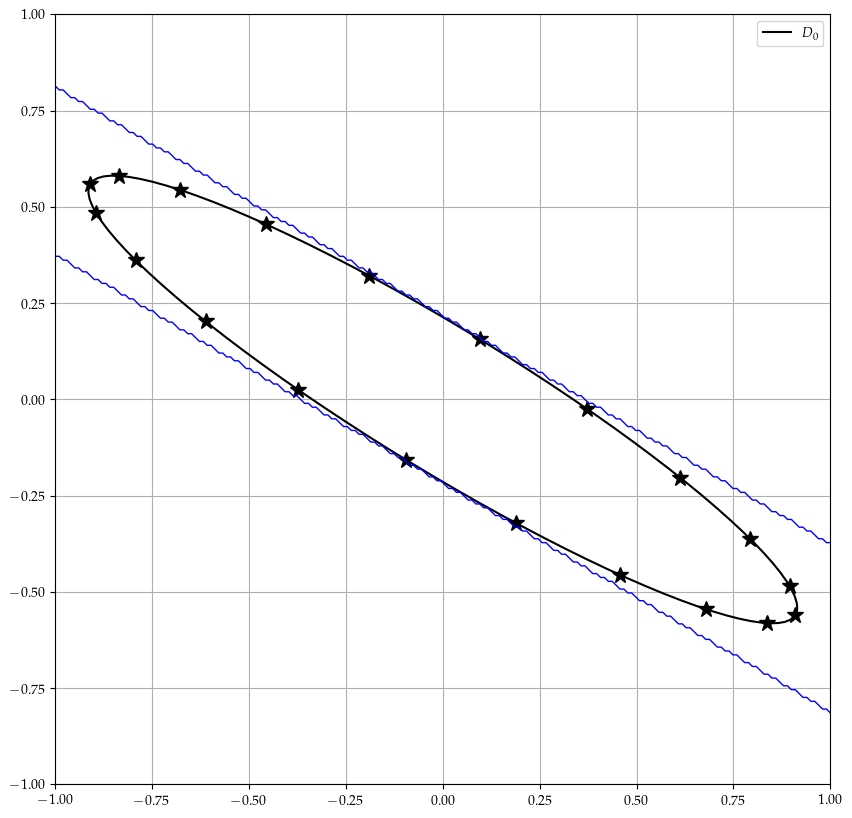

In [35]:
x1_range = (-0.6, 0.6)
x2_range = (-1., 1.)

# Iniciando a figura para o gráfico
fig, ax = plt.subplots(1, 1, figsize=(10., 10.))

num_points = 20

initial_states_list = nm.ellipsoid_boundary_points(P, 1., num_points)
plt.plot(initial_states_list[0], initial_states_list[1], '*',
         linestyle='None', c='black', markersize=12)

D0 = nm.get_ellipsoid_boundary(P, 1.)
plt.plot(D0['x1_vals'], D0['x2_vals'],
         'k-', label='$D_0$')

contour = ax.contour(X, Y, valid_points,
                     colors='blue', linewidths=1.)


plt.grid()
plt.legend()

In [36]:
def closedloop_simulation(x0, η0, T_s):
  N = len(timepts)
  nx = x0.shape[0]
  nu = params['amounts']['u']

  x = np.zeros((nx, N + 1, 1))
  x[:, 0, :] = x0
  η = np.zeros((N + 1, 1))
  η[0, :] = η0

  xτ = x0.copy()

  y = []
  uc = []

  ρ_hat = [0.]
  x_hat = x0
  event_times = [0.]
  trigger_async = [False]

  next_time_sampling = h

  def triggering_condition(η, x, ε, ρ):
    Tcal = x.T @ Ψ @ x - ε.T @ Ξ @ ε
    new_event = 0. * η + θ * Tcal[0][0] < 0
    triggering_by_async = False
    if not new_event:
      for i in range(params['amounts']['p']):
        new_event = np.abs(ρ[i] - ρ_hat[i]) > ρ_bar[i]
        if new_event:
          triggering_by_async = True
          break
    return new_event, triggering_by_async

  def etm_dynamics(t, η, u, params):
    ε = x_hat - xτ
    Tcal = xτ.T @ Ψ @ xτ - ε.T @ Ξ @ ε
    η_dot = - λ * η + Tcal[0][0]
    return η_dot

  def control_signal():
    α = (ρ_bounds[0][1] - ρ_hat) / (ρ_bounds[0][1] - ρ_bounds[0][0])
    uc_k = α * K[(0,)] @ x_hat + (1. - α) * K[(1,)] @ x_hat
    return np.array([[sgn.sat(uc_k[0, 0], u_bar[0])]])

  # uc_k = control_signal()

  for k in range(N):
    t = timepts[k]

    # print(η[k, :])
    # if η[k, :] < 0:
    #   print('η se tornou negativo')

    # Verificação da condição de acionamento
    if t >= next_time_sampling:
      next_time_sampling += h
      xτ = x[:, k, :]
      ε = x_hat - xτ
      new_event, triggering_by_async = triggering_condition(η[k], xτ, ε, ρ[k])
      if new_event:
        # print('event')
        x_hat = xτ
        ρ_hat = ρ[k]
        event_times.append(t)
        trigger_async.append(triggering_by_async)

        # Cálculo do sinal de controle

    uc_k = control_signal()
    util = np.vstack((uc_k, [ρ[k]]))

    # Saída da planta
    y_k = plant_output(t, x[:, k, :], util, params)

    # Atualização dos estados para o próximo passo (k+1)
    if k < N - 1:
      x[:, k + 1, :] = rk5_step(plant_dynamics, t,
                                x[:, k, :], util, T_s, params)
      η[k + 1, :] = rk5_step(etm_dynamics, t, η[k, :], None, T_s, None)

    # Armazena controle e saída em k
    uc.append(uc_k)
    y.append(y_k)

  return y, uc, η[:N], event_times, trigger_async

In [37]:
x0 = np.array([[0.1], [0.1]])
η0 = np.array([[0.]])
y, uc, η, event_times, trigger_async = closedloop_simulation(
    x0, η0, T_s=simulation_step)
inter_event_times = np.diff(event_times).tolist()

<>:32: SyntaxWarning: invalid escape sequence '\|'
<>:32: SyntaxWarning: invalid escape sequence '\|'
/tmp/ipykernel_4269/1386256494.py:32: SyntaxWarning: invalid escape sequence '\|'
  title='State norm - $\|x(t)\|$',


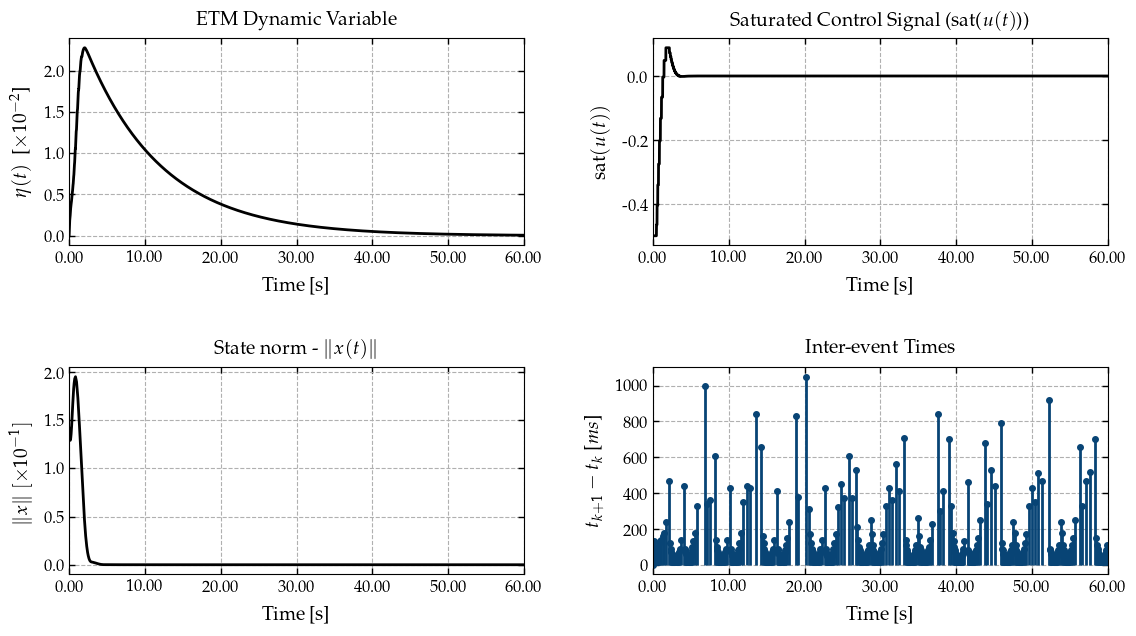

In [38]:
%matplotlib inline

fig, axs = plt.subplot_mosaic([['η', 'sat'], ['x', 'iet']], 
                              figsize=(12, 7))

plot_cfg = {
  'style': { 'color': 'black', },
  'axis': { 'title_pad': 10, 'y_digits': 1, 'x_digits': 2,
            'x_label_fontsize': 14,
            'y_label_fontsize': 14,
            'tick_fontsize': 14,},
  'limits': { 'x_min': 0., 'x_max': simulation_time,}
}


x_norm = np.array([np.linalg.norm(y_k) for y_k in y])

gph.plot(
    axs['η'], timepts, 
    [v * 1e2 for v in η],
    xlabel='Time [s]', ylabel='$\\eta(t)\\,$ [$\\times 10^{-2}$]',
    title='ETM Dynamic Variable',
    plot_cfg=plot_cfg)

inter_event_times = [0.0] + inter_event_times


# Plot sinal de saída
gph.plot(
    axs['x'], timepts, [v * 1e1 for v in x_norm],
    xlabel='Time [s]', ylabel=r'$\|x\|$ $[\times 10^{-1}]$',
    title='State norm - $\|x(t)\|$',
    plot_cfg=plot_cfg)

gph.plot(
    axs['sat'], timepts,
    [float(v[0, 0]) for v in uc],
    xlabel='Time [s]', ylabel='sat$(u(t))$',
    title='Saturated Control Signal (sat($u(t)$))', plot_cfg=plot_cfg)

# Plot dos IETs
if len(inter_event_times) > 0:
    stem_cfg = plot_cfg.copy()
    stem_cfg['axis']['y_digits'] = 0

    # Convertendo para milissegundos
    iet_ms = [et * 1e3 for et in inter_event_times]

    # Separando índices conforme o vetor booleano
    false_indexes = [i for i, val in enumerate(trigger_async) if not val]
    true_indexes = [i for i, val in enumerate(trigger_async) if val]


    # Eventos e tempos separados
    event_times_false = [event_times[i] for i in false_indexes]
    # print(iet_ms)
    iet_false = [iet_ms[i] for i in false_indexes]


    event_times_true = [event_times[i] for i in true_indexes]
    iet_true = [iet_ms[i] for i in true_indexes]

    # Plotando barras com cor azul para False
    if len(event_times_false) > 0:
      gph.stem(
          axs['iet'], event_times_false, iet_false,
          stem_cfg={**stem_cfg, 'style': {'color': '#084475'}},
          xlabel='Time [s]', ylabel='$t_{k+1} - t_k$ [$ms$]',
          title='Inter-event Times'
      )

    # Plotando barras com cor vermelha para True
    if len(event_times_true) > 0:
      gph.stem(
          axs['iet'], event_times_true, iet_true,
          stem_cfg={**stem_cfg, 'style': {'color': '#950101'}}
      )

else:
    axs['iet'].text(0.5, 0.5, 'No triggered events',
                    ha='center', va='center', fontsize=14,
                    transform=axs['iet'].transAxes)
    axs['iet'].set_title('Inter-event Times')
    axs['iet'].set_xlabel('Time [s]')
    axs['iet'].set_ylabel('$t_{k+1} - t_k$ [$ms$]')
    axs['iet'].set_xlim([0, simulation_time])
    axs['iet'].set_ylim([0, 1])  # valor simbólico
    axs['iet'].grid(False)

plt.tight_layout(pad=3.)